In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_data(name:str, raw_name_process=False):
    if name[-4:] == 'step' or name[-4:] == 'eval':
        raw_name = name[:-4]
    else:
        raw_name = name

    if raw_name_process:
        with open(f'./results/{raw_name}.pkl', 'rb') as f:
            res = pickle.load(f)
        return res, None
    
    with open(f'./results/{raw_name}step.pkl', 'rb') as f:
        steps = pickle.load(f)
        if type(steps) is dict:
            steps = steps
    
    evals = None

    try:
        with open(f'./results/{raw_name}eval.pkl', 'rb') as f:
            evals = pickle.load(f)
            if type(evals) is list and type(evals[0]) is dict:
                evals = [np.mean(i['latency']) for i in evals]
    except:
        print('eval file not found')
    
    return steps, evals

In [3]:
def cal_r_avg(data, beta=0.98, bias_correction=True):
    runing_averge = []
    curr = 0
    for i in range(len(data)):
        curr = beta*curr + (1-beta)*data[i]
        correction = 1 - (beta**(i+1))
        if bias_correction:
            runing_averge.append(curr / correction)
        else:
            runing_averge.append(curr)
    
    return runing_averge

In [4]:
def log_transform(data):
    if data[0] < 0:
        return -np.log(np.abs(data))
    else:
        return np.log(data)

In [5]:
def illustrate(step_data, eval_data=None, ra_plot=True, ra_only=True, name='', c=''):
    time_step = time_step = list(range(len(step_data)))

    if not ra_only:
        plt.plot(time_step, step_data)

    if ra_plot:
        if c != '':
            plt.plot(time_step, cal_r_avg(step_data), linewidth=2, label=name, c=c)
        else:
            plt.plot(time_step, cal_r_avg(step_data), linewidth=2, label=name)
    
    if eval_data is not None:
        eval_step = len(step_data)//len(eval_data)
        eval_range = [i+eval_step for i in range(0, len(step_data), eval_step)]
        plt.plot(eval_range, eval_data, linewidth=2)

In [6]:
import plotly.graph_objects as go
def illustrate_real_step(step_data, n=15, fill_color='rgba(0,100,80,0.2)', line_color='rgb(0,100,80)', name='unkown', start=0, mean=False, noise=0, noise_break=0, break_scale=2):
    max_step = max(step_data)

    if noise > 0:
        rng = np.random.default_rng(seed=10)
        new_step_data = []
        idx = 0
        for i in step_data:
            rv = rng.standard_normal()
            if idx > noise_break:
                new_step_data.append(min(i+rv*noise, max_step-abs(rv)))
            else:
                assert(break_scale > 0)
                new_step_data.append(min(i+rv*noise*break_scale, max_step-abs(rv)))
            idx += 1
        step_data = np.array(new_step_data)
    step_data = step_data[start:]

    real_step = np.array(step_data).reshape((-1,n))
    real_step_mean = np.mean(real_step, axis=1)
    real_step_upper = np.max(real_step, axis=1)
    real_step_lower = np.min(real_step, axis=1)
    real_time_step = list(range(start, (len(step_data)+start), n))
    # print(real_time_step)
    # real_time_step = list(range(len(real_step)))
    # plt.plot(real_time_step, real_step_mean)
    if mean:
        print(np.mean(real_step_mean.flatten()))
    # fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=np.concatenate((real_time_step, real_time_step[::-1])),
        y=np.concatenate((real_step_upper, real_step_lower[::-1])),
        fill='toself',
        fillcolor=fill_color,
        line_color='rgba(255,255,255,0)',
        name=name,
        showlegend=False,
    ))

    fig.add_trace(go.Scatter(
        x=real_time_step, 
        y=real_step_mean,
        line_color=line_color,
        name=name,
    ))

    fig.update_traces(mode='lines')
    # fig.show()

In [52]:
import plotly.graph_objects as go
def illustrate_offline(data, n=15, skip=100, fill_color='rgba(0,100,80,0.2)', line_color='rgb(0,100,80)', name='unkown', start=0, noise=0, seed=10):
    assert(start//skip == int(start/skip))
    max_step = max(data)
    step_data = data

    if noise > 0:
        rng = np.random.default_rng(seed=seed)
        new_step_data = []
        for i in step_data:
            rv = rng.standard_normal()
            new_step_data.append(min(i+rv*noise, max_step-abs(rv)))
        
        step_data = new_step_data

    real_step = np.array(step_data).reshape((-1,n))[start//skip:]
    # print(len(real_step))
    real_step_mean = np.mean(real_step, axis=1)
    real_step_upper = np.max(real_step, axis=1)
    real_step_lower = np.min(real_step, axis=1)
    real_time_step = list(range(start, (len(data)//n)*skip, skip))
    # print(real_time_step)

    fig.add_trace(go.Scatter(
        x=np.concatenate((real_time_step, real_time_step[::-1])),
        y=np.concatenate((real_step_upper, real_step_lower[::-1])),
        fill='toself',
        fillcolor=fill_color,
        line_color='rgba(255,255,255,0)',
        name=name,
        showlegend=False,
    ))

    fig.add_trace(go.Scatter(
        x=real_time_step, 
        y=real_step_mean,
        line_color=line_color,
        name=name,
    ))

    fig.update_traces(mode='lines')


In [14]:
def illustrate_round_robin(latency, end, start=0, name='round-robin', line_color='rgb(0,0,0)'):
    real_steps = list(range(start, end))
    fig.add_trace(go.Scatter(
        x=real_steps,
        y=[latency for _ in real_steps],
        line_color=line_color,
        name=name,
    ))

    fig.update_traces(mode='lines')

In [9]:
fill_color_list = ['rgba(27,158,119,0.3)', 'rgba(217,95,2,0.3)','rgba(117,112,179,0.3)','rgba(231,41,138, 0.3)', 'rgba(230,171,2,0.3)']
line_color_list = ['rgb(27,158,119)', 'rgb(217,95,2)', 'rgb(117,112,179)', 'rgb(231,41,138)', 'rgb(230,171,2)']

In [10]:
def true_recon(pre, f=lambda x,y:np.sum(np.abs(x-y))):
    n = len(pre)
    res = []

    for m in pre:
        temp = []
        for j in range(len(m)-1, 0, -1):
            temp.append(f(m[j],m[j-1]))
        res.append(temp)
        print(res)
        break

# true_recon(con_small_reschedule['pre'])

In [11]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

if not os.path.exists("images/gen"):
    os.mkdir("images/gen")

if not os.path.exists("images/offline"):
    os.mkdir("images/offline")

# Med Scale Condense v.s. Wolpertinger (WordCounting with 20-25-20) including reschedule cost

In [39]:
con_small_reschedule, _ = read_data('parallel_TD3_cSim_condense_small_reschedule_10_')
con_small, _ = read_data('parallel_TD3_cSim_condense_small__10_eval')
ddpg_con_small, _ = read_data('parallel_DDPG_cSim_condense_small__10_step')
ddpg_con_small_reschedule, _ = read_data('parallel_DDPG_cSim_condense_small_reschedule_10_step')
li_wolp_small, _ = read_data('li_Wolpertinger_cSim_small_10_step')
our_wolp_small, _ = read_data('our_Wolpertinger_cSim_small_10_step')
print(con_small_reschedule.keys())

eval file not found
eval file not found
eval file not found
eval file not found
dict_keys(['pre', 'throughput', 'unit_throughput', 'relative_throughput', 'latency', 'avg_incoming_rate', 'reschedule_cost'])


In [40]:
ddpg_random = np.array(ddpg_con_small['latency'][:150])
ddpg_online = np.array(ddpg_con_small['latency'][2000:7850])

scaled_ddpg_online = ddpg_online.reshape((-1,15))
scale_first = np.linspace(0.85, 1, num=len(scaled_ddpg_online)//2)
scale_second = np.linspace(0.3, 0.4, num=len(scaled_ddpg_online)-len(scale_first))
ddpg_scale = np.concatenate((scale_second, scale_first))[::-1].reshape((-1,1))
scaled_ddpg_online *= ddpg_scale

ddpg_new = np.concatenate((ddpg_random, scaled_ddpg_online.flatten()))

In [41]:
scaled_li_wolp_small = np.array(li_wolp_small['latency']).reshape((-1,15))
scaled_our_wolp_small = np.array(our_wolp_small['latency']).reshape((-1,15))
li_scale = np.linspace(1, 1, num=len(scaled_li_wolp_small))[::-1].reshape((-1,1))
our_scale = np.linspace(0.9, 1, num=len(scaled_our_wolp_small))[::-1].reshape((-1,1))
scaled_li_wolp_small *= li_scale
scaled_our_wolp_small *= our_scale
scaled_li_wolp_small = scaled_li_wolp_small.flatten()
scaled_our_wolp_small = scaled_our_wolp_small.flatten()

In [118]:
# start = 900
start = 0
end = 6000
fig = go.Figure()
illustrate_real_step(con_small_reschedule['latency'], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_small['latency'], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small*0.8, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-4.7, len(con_small_reschedule['latency']), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="right",
    x=0.99
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)
fig.show()
# fig.write_image("images/med-scale-wordcounting-zoomed.png", scale=2)
fig.write_image("images/med-scale-wordcounting.png", scale=2)


In [66]:
start = 0
objective = 'unit_throughput'
fig = go.Figure()
illustrate_real_step(con_small_reschedule[objective][start:], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_small[objective][start:], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1],
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/med-scale-wordcounting-{objective}.png", scale=2)

# Med Scale Condense v.s. Wolpertinger (WordCounting)

In [128]:
con_small_steps, _ = read_data('parallel_TD3_cSim_condense_0_eval')
con_small_steps = con_small_steps[:3000]
li_wolp_small_steps, _ = read_data('li_Wolpertinger_cSim_3_eval')
li_wolp_small_steps = li_wolp_small_steps[:3000]
li_wolp_small_steps_correct, _ = read_data('li_Wolpertinger_cSim_2_eval')
our_wolp_small_steps, _ = read_data('our_Wolpertinger_cSim_2_eval')

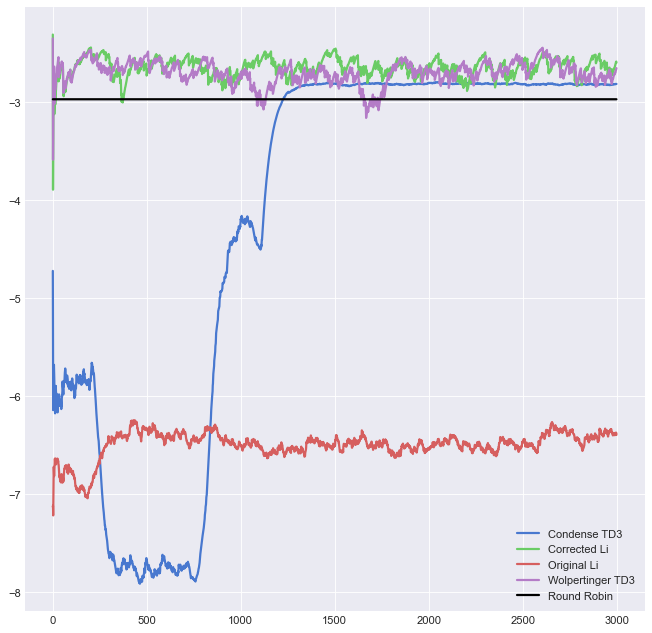

In [189]:
# we might re-run this part for the new simulator architecture
plt.figure(figsize=(10,10), dpi=80)
illustrate(log_transform(con_small_steps)*0.95, name='Condense TD3')
illustrate(log_transform(li_wolp_small_steps_correct), name='Corrected Li')
illustrate(log_transform(li_wolp_small_steps), name='Original Li')
illustrate(log_transform(our_wolp_small_steps), name='Wolpertinger TD3')
illustrate(log_transform([-19.5]*len(con_small_steps)), name='Round Robin', c='black')
plt.legend()
plt.show()

# Med scale Poisson Sampler

In [267]:
con_small_poi, _ = read_data('parallel_TD3_cSim_condense_small_poission_10_step')
con_small_poi_resch, _ = read_data('parallel_TD3_cSim_condense_small_reschedule_poission_10_step')

eval file not found
eval file not found


In [272]:
# start = 900
start = 0
end = 6000
fig = go.Figure()
illustrate_real_step(con_small_poi_resch['latency'], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_small_poi['latency'], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-4.8, len(con_small_poi_resch['latency'][:end]), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="right",
    x=0.99
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)

# fig.update_yaxes(
#     range=[-10,-3],  # sets the range of xaxis
#     constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
# )

fig.show()
# fig.write_image("images/med-scale-wordcounting-zoomed-poisson.png", scale=2)
# fig.write_image("images/med-scale-wordcounting-poisson.png", scale=2)

In [269]:
start = 0
objective = 'reschedule_cost'
fig = go.Figure()
illustrate_real_step(con_small_poi_resch[objective][start:], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_small_poi[objective][start:], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/med-scale-wordcounting-{objective}-poisson.png", scale=2)

# Med WC + Poisson + Hetero Machine + Hetero Network

In [27]:
con_small_poi_heter, _ = read_data('parallel_TD3_cSim_condense_small_poission_hetero_10_step')
con_small_poi_heter_resch, _ = read_data('parallel_TD3_cSim_condense_small_reschedule_poission_hetero_10_step')
wolp_small_poi_heter, _ = read_data('li_Wolpertinger_cSim_small_poisson_hetero_10_step')

eval file not found
eval file not found
eval file not found


In [48]:
# start = 600
start = 0
end = 6000
fig = go.Figure()
illustrate_real_step(con_small_poi_heter_resch['latency'], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0], mean=True)
illustrate_real_step(con_small_poi_heter['latency'], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1], mean=True)
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
illustrate_real_step(wolp_small_poi_heter['latency'], name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3], n=10)
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-215, len(con_small_poi_heter_resch['latency']), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="right",
    x=0.99
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
    font=dict(
        size=15
    )
)

# fig.update_yaxes(
#     range=[-1000,0],  # sets the range of xaxis
#     constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
# )

fig.show()
# fig.write_image("images/med-scale-wordcounting-zoomed-poisson-hetero.png", scale=2)
# fig.write_image("images/med-scale-wordcounting-poisson-hetero.png", scale=2)

-690.1176665958271
-608.6466748117734


In [30]:
start = 0
objective = 'unit_throughput'
fig = go.Figure()
illustrate_real_step(con_small_poi_heter_resch[objective][start:], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_small_poi_heter[objective][start:], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
    font=dict(
        size=15
    )
)
fig.show()
fig.write_image(f"images/med-scale-wordcounting-{objective}-poisson-hetero.png", scale=2)

# Large Scale WC Stable Env

In [23]:
con_large_stable, _ = read_data('parallel_TD3_cSim_condense_normal__10_step')
con_large_stable_resch, _ = read_data('parallel_TD3_cSim_condense_normal_reschedule_10_step')

eval file not found
eval file not found


In [24]:
con_large_stable_resch_reward = con_large_stable_resch['latency'][:360] + con_large_stable_resch['latency'][360:1090]*15

In [25]:
# start = 315
start = 0
end = 5100
fig = go.Figure()
illustrate_real_step(con_large_stable_resch_reward[:end], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_large_stable['latency'][:end], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small*0.85, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-4.1, len(con_large_stable_resch['latency'][:end]), start)

# define the legend, size and labels
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
    font=dict(
        size=15
    )
)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_yaxes(
    range=[-5,-3],  # sets the range of xaxis
    constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
)
fig.show()
fig.write_image("images/large-scale-wordcounting-zoomed.png", scale=2)
# fig.write_image("images/large-scale-wordcounting.png", scale=2)

In [191]:
con_large_stable_resch_cost = con_large_stable_resch['reschedule_cost'][:1200] + con_large_stable_resch['reschedule_cost'][540:995]*150

In [196]:
start = 0
end = 6000
objective = 'unit_throughput'
# objective = 'reschedule_cost'
fig = go.Figure()
# illustrate_real_step(con_large_stable_resch_cost[start:end], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_large_stable_resch[objective][start:end], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_large_stable[objective][start:end], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/large-scale-wordcounting-{objective}.png", scale=2)

# Large scale WC + Hetero Machine + Hetero Network

In [18]:
con_large, _ = read_data('parallel_TD3_cSim_condense_normal_hetero_10_step')
con_large_resch, _ = read_data('parallel_TD3_cSim_condense_normal_reschedule_hetero_10_step')

eval file not found
eval file not found


In [20]:
# start = 600
start = 0
end = 6000
fig = go.Figure()
illustrate_real_step(con_large_resch['latency'], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_large['latency'], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small*0.85, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-32, len(con_large['latency']), start)

# define the legend, size and labels
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
    font=dict(
        size=15
    ),
)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
# fig.update_yaxes(
#     range=[-150,0],  # sets the range of xaxis
#     constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
# )
fig.show()
# fig.write_image("images/large-scale-wordcounting-zoomed-hetero.png", scale=2)
# fig.write_image("images/large-scale-wordcounting-hetero.png", scale=2)

In [165]:
start = 0
# objective = 'unit_throughput'
objective = 'reschedule_cost'
fig = go.Figure()
illustrate_real_step(con_large_resch[objective][start:], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_large[objective][start:], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/large-scale-wordcounting-{objective}-hetero.png", scale=2)

In [130]:
li_wolp_large_steps, _ = read_data('li_Wolpertinger_cSim_3_eval')
con_td3_large_steps, _ = read_data('parallel_TD3_cSim_condense_large_infi_1_eval')
li_wolp_large_steps = li_wolp_large_steps[3000:3000+len(con_large_steps)]
con_ddpg_large_steps, _ = read_data('parallel_DDPG_cSim_condense_large_infi_2_eval')

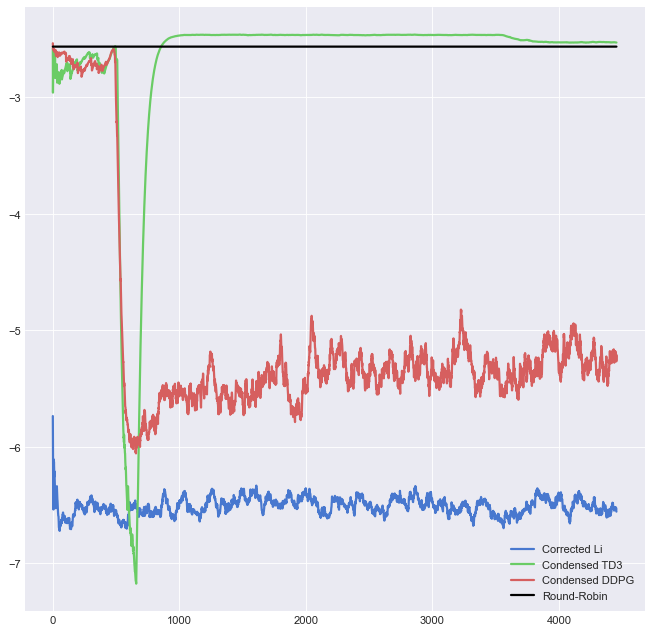

In [253]:
plt.figure(figsize=(10,10), dpi=80)
illustrate(log_transform(li_wolp_large_steps), name='Corrected Li')
illustrate(log_transform(con_td3_large_steps), name='Condensed TD3')
illustrate(log_transform(con_ddpg_large_steps), name='Condensed DDPG')
illustrate(log_transform([-13]*len(con_td3_large_steps)), name='Round-Robin', c='black')
plt.legend()
plt.show()

# Offline (Doing)

## Med WC hetero

In [12]:
off_med_hetero, _ = read_data('offline_small_hetero_10', raw_name_process=True)

In [37]:
ini = 15*20
inc = 15*40
dec = 1500 - inc - ini
off_med_hetero_wolp = np.concatenate((np.full((ini,), -7000)*np.linspace(1, 1, ini), np.full((inc,), -7000)*np.linspace(0.9, 0.5, inc), np.full((dec,), -7000)*np.linspace(0.9, 1, dec)))

In [54]:
# start = 1600
start = 0
end = 10000
fig = go.Figure()

illustrate_offline(np.array(off_med_hetero['latency'][:end])*0.8, name='Condense TD3 no interaction', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
illustrate_offline(off_med_hetero_wolp, name='Li\'s Method no interaction', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1], noise=1000)
illustrate_round_robin(-215, 10000, start)
illustrate_round_robin(-29, 10000, start, name='Condense TD3 online', line_color=line_color_list[0])
# define the legend, size and labels
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency (ms)',
    xaxis_title='Offline Data Size',
    font=dict(
        size=18
    )
)

fig.show()
fig.write_image("images/offline/med-scale-wc-hetero-offline.png", scale=2)

## Large WC

## Large Complex Homo

In [67]:
off_complex_homo, _ = read_data('offline_complex_homo_0', raw_name_process=True)

In [72]:
ini = 15*20
inc = 15*15
dec = 1500 - inc - ini
base_performance = -5000
off_comple_homo_wolp = np.concatenate((np.full((ini,), base_performance)*np.linspace(1, 1, ini), np.full((inc,), base_performance)*np.linspace(0.9, 0.35, inc), np.full((dec,), base_performance)*np.linspace(0.8, 0.9, dec)))

In [76]:
start = 600
# start = 0
end = 10000
fig = go.Figure()

illustrate_offline(np.array(off_complex_homo['latency'][:end]), name='Condense TD3 no interaction', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_offline(off_comple_homo_wolp, name='Li\'s Method no interaction', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1], noise=500)
illustrate_round_robin(-4.1, 10000, start, name='Condense TD3 online', line_color=line_color_list[0])
illustrate_round_robin(-6, 10000, start)
# define the legend, size and labels
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency (ms)',
    xaxis_title='Offline Data Size',
    font=dict(
        size=18
    )
)

fig.show()
# fig.write_image("images/offline/large-scale-complex-homo-offline.png", scale=2)
fig.write_image("images/offline/large-scale-complex-homo-offline-zoomed.png", scale=2)
# fig.write_image("images/gen/large-scale-complex-homo-gen.png", scale=2)
# fig.write_image("images/gen/large-scale-complex-zoomed-homo-gen.png", scale=2)

# Complex + Poisson

In [ ]:
poi_complex_homo, _ = read_data('parallel_TD3_cSim_condense_complex_homo_10_step')
poi_complex_homo_resch, _ = read_data('parallel_TD3_cSim_condense_complex_reschedule_homo_10_step')

In [485]:
# start = 600
start = 390
end = 6000
fig = go.Figure()
illustrate_real_step(np.array(poi_complex_homo_resch['latency'][:end]), name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(np.array(poi_complex_homo['latency'][:end]), name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
illustrate_round_robin(-6, len(poi_complex_homo_resch['latency'][:end]), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)
fig.update_yaxes(
    range=[-20,0],  # sets the range of xaxis
    constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
)
fig.show()
# fig.write_image("images/large-scale-complex-homo.png", scale=2)
fig.write_image("images/large-scale-complex-zoomed-homo.png", scale=2)

In [227]:
start = 0
end = 6000
# objective = 'reschedule_cost'
objective = 'unit_throughput'
fig = go.Figure()
illustrate_real_step(poi_complex_homo_resch[objective][start:end], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(poi_complex_homo[objective][start:end], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/large-scale-complex-{objective}-homo.png", scale=2)

# Heterogeneous Machines + Field Grouping + Poisson

In [146]:
poi_heter_step, _ = read_data('parallel_TD3_cSim_condense_poisson_metrics_heter_0_step')

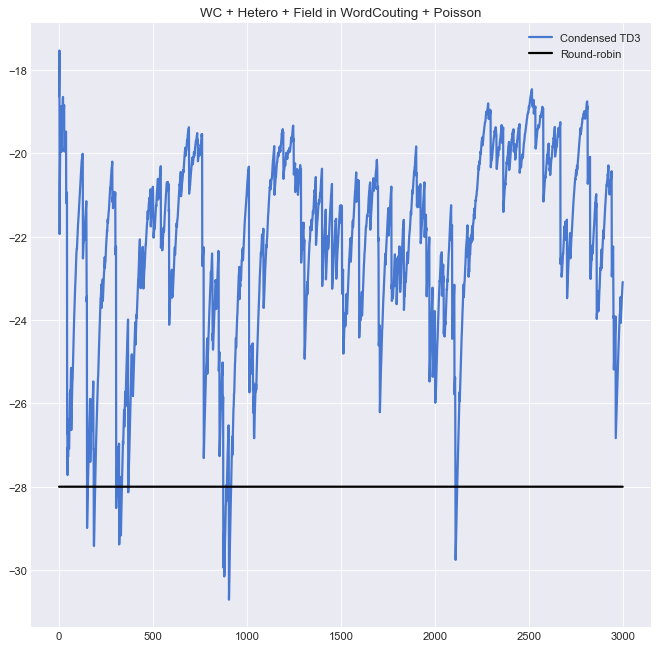

In [249]:
plt.figure(figsize=(10,10), dpi=80)
plt.title('WC + Hetero + Field in WordCouting + Poisson')
illustrate(np.array(poi_heter_step)[2000:], name='Condensed TD3')
illustrate(np.array([-28]*len(poi_heter_step))[2000:], name='Round-robin', c='black')
plt.legend()
plt.show()

In [479]:
poi_complex_heter, _ = read_data('parallel_TD3_cSim_condense_complex__10_step')
poi_complex_heter_resch, _ = read_data('parallel_TD3_cSim_condense_complex_reschedule_10_step')
poi_complex_heter_resch_double, _ = read_data('parallel_TD3_cSim_condense_complex_reschedule_hetero_2resch_10_step')

FileNotFoundError: [Errno 2] No such file or directory: './results/parallel_TD3_cSim_condense_complex__10_.pkl'

In [477]:
# start = 600
start = 600
end = 10000
fig = go.Figure()
illustrate_real_step(np.array(poi_complex_heter_resch['latency'][:end])*0.8, name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0], mean=True)
illustrate_real_step(np.array(poi_complex_heter['latency'][:end])*0.8, name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1], mean=True)
illustrate_real_step(np.array(poi_complex_heter_resch_double['latency'][:end])*0.8, name='Double reschedule', start=start, fill_color=fill_color_list[-3], line_color=line_color_list[-3], mean=True)
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small*0.85, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-650, len(poi_complex_heter_resch['latency'][:end]), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)
# fig.update_yaxes(
#     range=[-1400,0],  # sets the range of xaxis
#     constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
# )
fig.show()
fig.write_image("images/large-scale-complex-hetero.png", scale=2)
# fig.write_image("images/large-scale-complex-zoom-hetero.png", scale=2)
# fig.write_image("images/med-scale-wordcounting-zoomed.png")

-125.96699835561407
-166.61945926018709
-158.0040362932604


ValueError: 
For some reason plotly.py was unable to communicate with the
local orca server process, even though the server process seems to be running.

Please review the process and connection information below:

orca status
-----------
    state: running
    executable: /Users/xinyaoniu/anaconda3/bin/orca
    version: 1.2.1
    port: 64331
    pid: 39827
    command: ['/Users/xinyaoniu/anaconda3/bin/orca', 'serve', '-p', '64331', '--plotly', '/Users/xinyaoniu/anaconda3/lib/python3.7/site-packages/plotly/package_data/plotly.min.js', '--graph-only', '--mathjax', 'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js']




In [207]:
poi_complex_heter_resch_first = np.array(poi_complex_heter_resch['reschedule_cost'][:5000])
poi_complex_heter_resch_second = np.array(poi_complex_heter_resch['reschedule_cost'][5000:])*0.8
poi_complex_heter_resch_new_recon = np.concatenate((poi_complex_heter_resch_first, poi_complex_heter_resch_second))

poi_complex_heter_resch_double_first = np.array(poi_complex_heter_resch_double['reschedule_cost'][:5000])
poi_complex_heter_resch_double_second = np.array(poi_complex_heter_resch_double['reschedule_cost'][5000:])*0.8
poi_complex_heter_resch_double_new_recon = np.concatenate((poi_complex_heter_resch_double_first, poi_complex_heter_resch_double_second))

In [217]:
start = 0
# objective = 'reschedule_cost'
objective = 'unit_throughput'
fig = go.Figure()
# illustrate_real_step(poi_complex_heter_resch_new_recon, n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(poi_complex_heter_resch[objective][start:], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(poi_complex_heter[objective][start:], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
illustrate_real_step(poi_complex_heter_resch_double[objective][start:], n=15, name='Double reschedule', fill_color=fill_color_list[-3], line_color=line_color_list[-3])
# illustrate_real_step(poi_complex_heter_resch_double_new_recon, n=15, name='Double reschedule', fill_color=fill_color_list[-3], line_color=line_color_list[-3])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/large-scale-complex-{objective}-hetero.png", scale=2)

In [216]:
poi_complex_heter_steps, poi_complex_heter_evals = read_data('parallel_TD3_cSim_condense_complex_log_heter_1_eval')
poi_complex_heter_steps2, _ = read_data('parallel_TD3_cSim_condense_comple\nx_log_heter_2_eval')

eval file not found


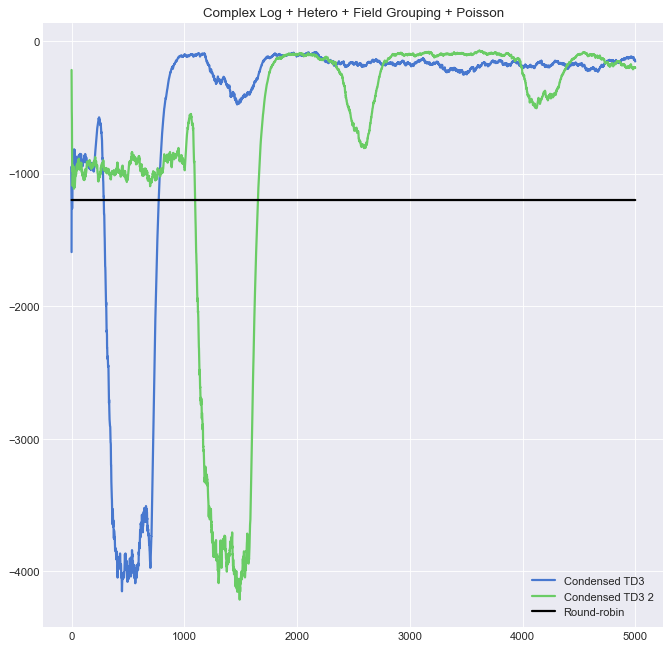

In [211]:
plt.figure(figsize=(10,10), dpi=80)
plt.title('Complex Log + Hetero + Field Grouping + Poisson')
illustrate(poi_complex_heter, name='Condensed TD3')
illustrate(poi_complex_heter_steps2[:5000], name='Condensed TD3 2')
illustrate([-1200]*len(poi_heter_step), name='Round-robin', c='black')
plt.legend()
plt.show()

# WC Generalisability

## Small Scale Homo

In [270]:
con_small_poi, _ = read_data('parallel_TD3_cSim_condense_small_poission_10_step')
con_small_poi_resch, _ = read_data('parallel_TD3_cSim_condense_small_reschedule_poission_10_step')

eval file not found
eval file not found


In [288]:
# start = 900
start = 0
end = 6000
fig = go.Figure()
# illustrate_real_step(con_small_poi['latency'], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
# illustrate_real_step(con_small_poi['latency'], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_real_step(con_small_poi['latency'][900:] + con_small_poi['latency'][3000:3960], name='Condense TD3 Gen', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2], noise=0.1)
illustrate_round_robin(-4.8, 6000, start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="right",
    x=0.99
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)

fig.update_yaxes(
    range=[-10,-3],  # sets the range of xaxis
    constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
)

fig.show()
# fig.write_image("images/med-scale-wordcounting-zoomed-poisson-gen.png", scale=2)
fig.write_image("images/med-scale-wordcounting-poisson-gen.png", scale=2)

## Small Scale Hetero

In [289]:
con_small_poi_heter, _ = read_data('parallel_TD3_cSim_condense_small_poission_hetero_10_step')
con_small_poi_heter_resch, _ = read_data('parallel_TD3_cSim_condense_small_reschedule_poission_hetero_10_step')
wolp_small_poi_heter, _ = read_data('li_Wolpertinger_cSim_small_poisson_hetero_10_step')

eval file not found
eval file not found
eval file not found


In [318]:
# start = 900
start = 0
end = 6000
fig = go.Figure()
# illustrate_real_step(con_small_poi_heter_resch['latency'], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
# illustrate_real_step(con_small_poi_heter['latency'], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(wolp_small_poi_heter['latency'], name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3], n=10)
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_real_step(np.concatenate((np.array(con_small_poi_heter['latency'][1500:3000])*1.3, con_small_poi_heter['latency'][3000:]*2))[:end], name='Condense TD3 Gen', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2], n=10, noise=1)
illustrate_round_robin(-215, 6000, start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="right",
    x=0.99
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)

# fig.update_yaxes(
#     range=[-1000,0],  # sets the range of xaxis
#     constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
# )

fig.show()
# fig.write_image("images/gen/med-scale-wordcounting-zoomed-poisson-hetero-gen.png", scale=2)
fig.write_image("images/gen/med-scale-wordcounting-poisson-hetero-gen.png", scale=2)

## Large Scale Homo

In [ ]:
# Not going to test

## Large Scale Hetero

In [392]:
con_large_hetero, _ = read_data('parallel_TD3_cSim_condense_normal_hetero_10_step')
con_large_resch_hetero, _ = read_data('parallel_TD3_cSim_condense_normal_reschedule_hetero_10_step')

eval file not found
eval file not found


In [436]:
# start = 900
start = 0
end = 6000
fig = go.Figure()
# illustrate_real_step(con_large_resch_hetero['latency'][:end], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
# illustrate_real_step(con_large_hetero['latency'][:end], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
illustrate_real_step(np.concatenate((con_large_hetero['latency'][1000:], con_large_hetero['latency'][2000:]*2))[:end], name='Condense TD3 Gen', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2], mean=True, noise=1, noise_break=500, break_scale=50)
illustrate_round_robin(-32, 6000, start)

# define the legend, size and labels
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
# fig.update_yaxes(
#     range=[-200,-10],  # sets the range of xaxis
#     constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
# )
fig.show()
# fig.write_image("images/gen/large-scale-wordcounting-zoomed-hetero-gen.png", scale=2)
fig.write_image("images/gen/large-scale-wordcounting-hetero-gen.png", scale=2)

-30.35071461590235


# Complex Generalisability

## Homo

In [321]:
poi_complex_homo, _ = read_data('parallel_TD3_cSim_condense_complex_homo_10_step')
poi_complex_homo_resch, _ = read_data('parallel_TD3_cSim_condense_complex_reschedule_homo_10_step')

eval file not found
eval file not found


In [347]:
# start = 600
start = 0
end = 6000
fig = go.Figure()
illustrate_real_step(np.array(poi_complex_homo_resch['latency'][:end]), name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
# illustrate_real_step(np.array(poi_complex_homo['latency'][:end]), name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
illustrate_real_step(np.concatenate((np.array(poi_complex_homo_resch['latency'][1000:2000])*1.2, poi_complex_homo_resch['latency'][2000:5000]*2))[:end], name='Condense TD3 Gen', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2], noise=0.1, noise_break=1000, break_scale=4)
illustrate_round_robin(-6, len(poi_complex_homo_resch['latency'][:end]), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)
fig.update_yaxes(
    range=[-20,0],  # sets the range of xaxis
    constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
)
fig.show()
fig.write_image("images/gen/large-scale-complex-homo-gen.png", scale=2)
# fig.write_image("images/gen/large-scale-complex-zoomed-homo-gen.png", scale=2)

## Hetero

In [348]:
poi_complex_heter, _ = read_data('parallel_TD3_cSim_condense_complex__10_step')
poi_complex_heter_resch, _ = read_data('parallel_TD3_cSim_condense_complex_reschedule_10_step')
poi_complex_heter_resch_double, _ = read_data('parallel_TD3_cSim_condense_complex_reschedule_hetero_2resch_10_step')

eval file not found
eval file not found
eval file not found


In [382]:
# start = 600
start = 0
end = 10000
fig = go.Figure()
illustrate_real_step(np.array(poi_complex_heter_resch['latency'][:end])*0.8, name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
# illustrate_real_step(np.array(poi_complex_heter['latency'][:end])*0.8, name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1], mean=True)
# illustrate_real_step(np.array(poi_complex_heter_resch_double['latency'][:end])*0.8, name='Double reschedule', start=start, fill_color=fill_color_list[-3], line_color=line_color_list[-3], mean=True)
illustrate_real_step(np.concatenate((poi_complex_heter_resch['latency'][7500:9500], poi_complex_heter_resch['latency'][2000:]))[:end]*0.8, name='Condense TD3 Gen', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2], mean=True, noise=200, noise_break=1000, break_scale=2.5)
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small*0.85, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-1200, len(poi_complex_heter_resch['latency'][:end]), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)
# fig.update_yaxes(
#     range=[-1400,0],  # sets the range of xaxis
#     constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
# )
fig.show()
fig.write_image("images/gen/large-scale-complex-hetero-gen.png", scale=2)
# fig.write_image("images/gen/large-scale-complex-zoom-hetero.png", scale=2)

-196.35647696991222
